In [1]:
import pandas as pd
import torch
from torch_geometric.data import InMemoryDataset
import numpy as np
from torch_geometric.data import Data
import statistics
from tqdm import tqdm

In [2]:
df = pd.read_csv(r'../dataset/Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv')
df_us_101 = df[df["Location"] == "us-101"].drop_duplicates()
df_us_101 = df_us_101.sort_values(by=['Global_Time'])
df_us_101 = df_us_101[["Vehicle_ID", "Frame_ID", "Local_X", "Local_Y", "v_Vel", "Following", "Global_Time"]]

df_us_101['Following'] = df_us_101['Following'] + 1
df_us_101['Vehicle_ID'] = df_us_101['Vehicle_ID'] + 1

In [3]:
df_us_101.columns

Index(['Vehicle_ID', 'Frame_ID', 'Local_X', 'Local_Y', 'v_Vel', 'Following',
       'Global_Time'],
      dtype='object')

In [4]:
x = list(df_us_101['Local_X'])
y = list(df_us_101['Local_Y'])
v = list(df_us_101['v_Vel'])
mean_x = sum(x)/len(x)
mean_y = sum(y)/len(y)
mean_v = sum(v)/len(v)

In [5]:
std_x = statistics.pstdev(x)
std_y = statistics.pstdev(y)
std_v = statistics.pstdev(v)

In [6]:
new_x = [(x1-mean_x)/std_x for x1 in x]
new_y = [(y1-mean_y)/std_y for y1 in y]
new_v = [(v1-mean_v)/std_v for v1 in v]

In [7]:
df_us_101['new_x'] = new_x
df_us_101['new_y'] = new_y
df_us_101['new_v'] = new_v

In [8]:
global_times = sorted(set(list(df_us_101['Global_Time'])))
time_len = len(global_times)

time1 = global_times[int(time_len/3 - 600)]
time2 = global_times[int(time_len/3 * 2 + 300)]

In [10]:
# seperate the dataset to three subsets, the dataset is generated from three videos, each video is 15 minutes
df_1 = df_us_101[df_us_101['Global_Time'] < time1]
df_2 = df_us_101[df_us_101['Global_Time'] > time1]
df_2 = df_2[df_2['Global_Time'] < time2]
df_3 = df_us_101[df_us_101['Global_Time'] > time2]
# get vehicle IDs

In [11]:
v_2828 = df_1[df_1['Vehicle_ID'] == 2828]['v_Vel'].tolist()

In [12]:
plt.plot(v_2828)
plt.xlim((0, 600))
plt.ylim((0, 40))
plt.xlabel('frames (0.1s)')
plt.ylabel('speed (feet/s)')
plt.savefig('../images/vehicle_sample.png', dpi=300)

NameError: name 'plt' is not defined

In [13]:
for i in vid:
    v_df = df_1[df_1['Vehicle_ID'] == i]

NameError: name 'vid' is not defined

In [14]:
# get vehicle IDs
def get_vehicle_IDs(df):
    vehicles = sorted(set(list(df["Vehicle_ID"])))
    return vehicles

# get frame list, frame = frame_list[frame_index_in_df]
def get_frames(df):
    frames = sorted(set(list(df["Frame_ID"])))
    frames_list = [0] * (frames[-1]+1)
    for frame_index in frames:
        frame = df[df["Frame_ID"] == frame_index]
        frames_list[frame_index] = frame
    return frames_list

def get_x_y(frames, frame_list, V):
    x_list = []
    frame_y = []
    for f in frames[0:20]:
        frame = frame_list[f].copy()
        frame['Vehicle_ID'] = frame['Vehicle_ID'].replace(V, 1)
        frame['Following'] = frame['Following'].replace(1, 0)
        frame['Following'] = frame['Following'].replace(V, 1)
        frame = frame.sort_values(by=["Vehicle_ID"])
        frame['v_index'] = range(len(frame.index))

        frame_edge = frame[frame['Following'] != 0]
        edge_from = list(frame_edge['v_index'])
        edge_to_origin = list(frame_edge['Following'])
        edge_to = []
        vehicles_id = list(frame['Vehicle_ID'])
        for to_origin in edge_to_origin:
            new_v_index = vehicles_id.index(to_origin)
            edge_to.append(new_v_index)
        frame_x = torch.tensor(frame[['new_v', 'new_x', 'new_y']].values, dtype=torch.double)
        frame_edge = torch.tensor([edge_to, edge_from], dtype=torch.long)
        y = []
        data = Data(x=frame_x, y=y, edge_index=frame_edge)
        x_list.append(data)
    for f in frames[20:]:
        frame = frame_list[f]
        y = frame[frame['Vehicle_ID'] == V][['new_v']].values
        frame_y.append(y.tolist()[0])
    y_list = torch.FloatTensor(frame_y)
    return x_list, y_list

In [15]:
def prepare_dataset(df):
    data_x_list = []
    data_y_list = []
    # get vehicle IDs
    V_IDs = get_vehicle_IDs(df)
    print(V_IDs[-1])
    # get frame list:
    frame_list = get_frames(df)
    
    for V in V_IDs:
        print(V)
        frames = sorted(set(list(df[df['Vehicle_ID'] == V]['Frame_ID'])))
        frames_len = len(frames)
        if frames_len < 90:
            continue
        else:
            f_1 = frames[0:30]
            f_2 = frames[int(frames_len/3): int(frames_len/3) + 30]
            f_3 = frames[int(frames_len/3) * 2: int(frames_len/3) * 2 + 30]
            data_x, data_y = get_x_y(f_1, frame_list, V)
#             data_list.append([data_x, data_y])
            data_x_list.append(data_x)
            data_y_list.append(data_y)    
        
            data_x, data_y = get_x_y(f_2, frame_list, V)
#             data_list.append([data_x, data_y])
            data_x_list.append(data_x)
            data_y_list.append(data_y) 
        
            data_x, data_y = get_x_y(f_3, frame_list, V)
            data_x_list.append(data_x)
            data_y_list.append(data_y)
            
            
    return [data_x_list, data_y_list]

In [16]:
import random

In [17]:
dataset = prepare_dataset(df_1)

3110
3
5
6
7
9
10
11
13
14
15
19
21
22
23
24
26
27
28
32
33
34
35
36
38
40
41
43
44
45
48
49
50
52
54
55
56
57
58
60
61
63
64
65
68
70
72
73
74
75
76
77
78
79
80
83
84
85
91
92
95
96
97
98
100
101
105
106
110
115
116
117
118
119
120
121
122
123
125
126
128
129
132
133
135
136
137
138
140
141
142
143
145
146
147
148
151
152
153
154
158
159
160
162
163
164
165
168
170
171
175
176
177
180
181
182
183
184
185
191
192
193
195
197
199
200
201
204
205
206
207
213
214
215
216
217
218
220
221
222
224
225
226
227
228
229
231
232
233
234
235
238
240
241
242
243
246
247
248
250
251
253
254
255
256
258
272
273
278
279
280
281
282
283
285
286
290
291
293
296
297
298
299
301
302
303
305
306
307
309
310
311
312
320
321
322
323
324
325
329
330
331
332
333
340
341
343
345
346
347
348
351
352
353
357
358
359
364
365
366
367
368
369
373
374
375
376
377
380
381
382
384
385
388
389
390
394
395
396
397
398
400
401
402
403
404
405
406
408
409
411
412
416
417
418
419
420
423
424
425
427
428
432
434
435
436
437

2486
2487
2488
2491
2492
2493
2494
2495
2497
2498
2499
2501
2502
2503
2504
2505
2506
2509
2510
2511
2516
2517
2518
2520
2521
2523
2524
2525
2526
2529
2530
2531
2532
2533
2534
2537
2538
2539
2541
2543
2544
2545
2549
2550
2551
2553
2555
2556
2557
2558
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2576
2577
2578
2579
2580
2582
2583
2584
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2603
2604
2605
2606
2609
2610
2611
2613
2614
2616
2617
2618
2619
2620
2621
2622
2624
2625
2626
2629
2630
2631
2632
2634
2635
2636
2638
2640
2641
2642
2644
2645
2646
2647
2649
2650
2651
2654
2655
2657
2658
2659
2660
2661
2664
2665
2666
2669
2670
2671
2672
2673
2674
2675
2676
2679
2680
2681
2682
2683
2687
2688
2689
2690
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2704
2705
2706
2707
2708
2710
2711
2712
2714
2715
2716
2717
2718
2719
2720
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2735
2736
2737
2738
2741
2742
2743
2744
2746
2749
2750
2751
2753
2754
2755
2756


In [18]:
datasetZip = list(zip(dataset[0], dataset[1]))
random.shuffle(datasetZip)
x_random, y_random = zip(*datasetZip)
x_random, y_random = list(x_random), list(y_random)

In [19]:
dataset_shuffled = [x_random, y_random]

In [20]:
train_dataset = [x_random[0: int(len(x_random)*0.7)], y_random[0: int(len(x_random)*0.7)]]
val_dataset = [x_random[int(len(x_random)*0.7 ): int(len(x_random)*0.9)], y_random[int(len(x_random)*0.7 ): int(len(x_random)*0.9)]]
test_dataset = [x_random[int(len(x_random)*0.9):], y_random[int(len(x_random)*0.9):]]

In [21]:
test_dataset1 = [x_random[int(len(x_random)*0.9):], y_random[int(len(x_random)*0.9):]]

In [771]:
float(test_dataset1[0][0][0].x[0][0])

0.8644150762873042

In [762]:
v_list = [d[0] for d in test_dataset1[0][0][0].x]

In [763]:
v_list

[0.8644150762873042,
 1.383606792068045,
 1.381496256638042,
 1.034664934307547,
 1.3829032802580443,
 0.6800949820670407,
 1.1014985562576425,
 1.1176793278876653,
 1.016373627247521,
 2.086415090259049,
 1.140895217617699,
 1.0283333280175382,
 1.029036839827539,
 2.0800834839690396,
 1.5805900988683266,
 1.3449136425179902,
 1.830336791418683,
 1.2654168079878765,
 1.6474237208184217,
 1.3829032802580443,
 0.8981836431673522,
 1.361094414148013,
 1.381496256638042,
 1.6199867602283826,
 1.169035690017739,
 1.0304438634475412,
 1.5355653430282623,
 1.3821997684480434,
 1.7733523348086015,
 0.9446154226274187,
 0.6793914702570398,
 1.7346591852585465,
 1.187326997077765,
 1.368833044058024,
 0.4380869194266953,
 1.062101894897586,
 1.383606792068045,
 1.1500408711477117,
 0.014572809806090693,
 1.7459153742185622,
 1.031147375257542,
 0.6611001631970138,
 1.391345421978056,
 0.6793914702570398,
 -1.0793880547454713,
 0.668135281297024,
 1.7325486498285434,
 -0.7332602442249769,
 0.327

In [22]:
x_list_linear = []
for data in test_dataset1[0]:
    vel = []
    for d in data:
        vel.append(float(d.x[0][0]))
    x_list_linear.append(vel)

In [23]:
test_dataset1[1][0].numpy().reshape(-1).tolist()

[0.7384864687919617,
 0.7659234404563904,
 0.7659234404563904,
 0.7398934960365295,
 0.7075319290161133,
 0.68642657995224,
 0.672356367111206,
 0.6512510180473328,
 0.599894642829895,
 0.5281364321708679]

In [24]:
y_list_linear = []
data = test_dataset1[1]
for d in data:
    d1 = d.numpy().reshape(-1).tolist()
    y_list_linear.append(d1)

In [25]:
x_df = pd.DataFrame(x_list_linear)
x_df.to_csv(r'../images/test_x_list.csv')
y_df = pd.DataFrame(y_list_linear)
y_df.to_csv(r'../images/test_y_list.csv')

In [793]:
df_test = pd.read_csv(r'../images/test_x_list.csv')

In [803]:
df_test

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,0.864415,0.878485,0.876375,0.844717,0.787029,0.725823,0.689241,0.677281,0.676577,...,0.679391,0.679391,0.678688,0.677281,0.685020,0.706828,0.739190,0.765220,0.765220,0.739893
1,1,0.656879,0.672356,0.678688,0.677984,0.678688,0.680095,0.680798,0.680095,0.679391,...,0.677984,0.678688,0.680095,0.680095,0.678688,0.677281,0.686427,0.716678,0.775773,0.855269
2,2,1.031147,1.031147,1.031147,1.031147,1.031147,1.031147,1.031147,1.031147,1.031147,...,1.029037,1.038182,1.067026,1.118383,1.180292,1.224613,1.231648,1.209136,1.181699,1.168332
3,3,1.259085,1.239387,1.207025,1.158483,1.106423,1.064212,1.038182,1.029037,1.029740,...,1.031147,1.031147,1.031147,1.031147,1.031147,1.030444,1.029740,1.036775,1.059288,1.102202
4,4,0.046934,0.046934,0.046934,0.046934,0.046934,0.046934,0.056784,0.124321,0.199596,...,0.327636,0.388841,0.446529,0.484519,0.440197,0.290349,0.114471,-0.015678,-0.044522,0.019497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,632,1.031147,1.031147,1.031147,1.031147,1.031147,1.031147,1.031147,1.031147,1.032554,...,1.026926,0.970645,0.851048,0.747632,0.709642,0.739893,0.792657,0.789843,0.742004,0.701904
633,633,-0.024120,-0.024120,-0.024120,-0.024120,-0.024120,-0.024120,-0.024120,-0.024120,-0.024120,...,-0.024120,-0.024120,-0.024120,-0.024120,-0.024120,-0.024120,-0.050854,-0.112059,-0.156381,-0.156381
634,634,1.854256,1.800086,1.760689,1.739584,1.733252,1.730438,1.724107,1.728328,1.759986,...,1.912648,1.992848,2.047018,2.074455,2.083601,2.086415,2.087119,2.087119,2.087119,2.086415
635,635,2.160284,2.191238,2.200384,2.198977,2.197570,2.197570,2.197570,2.197570,2.197570,...,2.197570,2.192645,2.179279,2.170837,2.170837,2.176465,2.184203,2.188424,2.191238,2.190535


In [801]:
len(test_dataset[0])

TypeError: 'function' object is not subscriptable

In [26]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
from torch.utils.data import Dataset
class NGSIMDataset(Dataset):
    
    def __init__(self, data_list, transform=None):
        self.data = data_list
        self.transform = transform
        self.x_list = data_list[0]
        self.y_list = data_list[1]
        
    def __len__(self):
        return len(self.data[0])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.x_list[idx]
        y = self.y_list[idx]
        
        return x, y
        
#         sample = {'graphs': x, 'y': y}
        
#         if self.transform:
#             sample = self.transform(sample)
        
#         return sample

In [29]:
import torch_geometric.transforms as T
# transform = T.Compose([T.NormalizeScale()])

In [30]:
train_d = NGSIMDataset(train_dataset)
test_d = NGSIMDataset(test_dataset)
val_d = NGSIMDataset(val_dataset)

In [31]:
# new_data_y = []
# for d in dataset[1]:
#     new_data_y.append(d.tolist())

In [32]:
# new_data_y = np.array(new_data_y).reshape(-1)

In [33]:
# plt.hist(new_data_y)

In [34]:
from torch_geometric.data import DataLoader

train_dataloader = DataLoader(train_d, batch_size=128, shuffle=True)

val_dataloader = DataLoader(val_d, batch_size=64, shuffle=True)

In [35]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
import os

In [36]:
device = torch.device('cuda')
class Net(torch.nn.Module):
    def __init__(self, batch, time_number, LSTM_hidden, GCN_hidden):
        super(Net, self).__init__()
        
        self.batch_size = batch
        self.time_number = time_number
        self.LSTM_hidden = LSTM_hidden
        self.GCN_hidden = GCN_hidden
        self.num_layers = 4
        
        self.conv1 = GCNConv(3, 32)
        self.conv3 = GCNConv(32, 32)
        self.conv2 = GCNConv(32, self.GCN_hidden)
        self.lstm = nn.LSTM(
            input_size = GCN_hidden,
            hidden_size = LSTM_hidden,
            num_layers=self.num_layers
        )
        
        self.linear1 = nn.Linear(in_features=self.LSTM_hidden, out_features=30)
        self.linear2 = nn.Linear(in_features=30, out_features = 10)
        

    
    def forward(self, data):
        predict = []
#         result_tensor = 
#         print(len(data))
        for i in range(len(data)):
            x_list = []
            x, edge_index = data[i].x, data[i].edge_index
#             print(x)
            
            batch_list = data[i].batch.cpu().numpy()
            batch_size = len(set(batch_list))

            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            
            x = self.conv3(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            
            x = self.conv3(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            
            x = self.conv2(x, edge_index)
            
            x_list.append(x[0])
            for i in range(1, len(batch_list)):
                if batch_list[i] > batch_list[i-1]:
                    x_list.append(x[i])

                    
            predict.append(torch.cat(x_list, dim=0).view(batch_size, self.GCN_hidden))
#         final = torch.stack([torch.cat(sub_list, dim=0) for sub_list in predict], dim=0)
#         my_tensor = torch.FloatTensor(predict)
        h0 = torch.zeros(self.num_layers, batch_size, self.LSTM_hidden).requires_grad_().double().to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.LSTM_hidden).requires_grad_().double().to(device)

        x_LSTM = torch.cat(predict, dim=0).view(self.time_number, batch_size, self.GCN_hidden)
        
        _, (hn, _) = self.lstm(x_LSTM, (h0, c0))
        out = self.linear1(hn[0])
        out = self.linear2(out).flatten()
    
        return out

In [37]:
# def mse(prediction, y):
#     square = torch.square(prediction - y)
#     batch_mean = torch.mean(square, dim=1)
#     mean = torch.mean(batch_mean, dim=0)
#     l_x = mean[0]
#     l_y = mean[1]
#     l_v = mean[2]
#     return (l_x + l_y)/2

In [38]:
def test_dataset(dataloader, model, std_v, mean_v):
    loss = []
    for graph, y in dataloader:
        batch_size = y.shape[0]
        graph_gpu = []
        for data in graph:
            data.to(device)
            graph_gpu.append(data)
        prediction = model(graph_gpu).view(batch_size, 10, 1)
        y = y.double().to(device)
        l = torch.sqrt(loss_function(prediction, y).double())
        loss.append(l.item() * std_v)
    loss_avg = sum(loss) / len(loss)
    return loss_avg

In [562]:
batch_size = 128
time_number = 20
LSTM_hidden = 32
GCN_hidden = 10

# train_dataloader = DataLoader(dataset_a, batch_size=batch_size)
model = Net(batch_size, time_number, LSTM_hidden, GCN_hidden).double()
model.to(device)

learning_rate = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

i = 0
EPOCHS = 5000
location_loss1 = []
v_loss = []
l_lowest = 999999999
for e in range(EPOCHS):
#     print("epoch:  ", e , "-------------")
    l_l = []

    loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader))
#     for graph, y in train_dataloader:
    for step, (graph, y) in loop:
        batch_size = y.shape[0]
#         y.to(device)
    #     print(y)
        graph_gpu = []
        for data in graph:
#             print(data.x)
            data.to(device)
            graph_gpu.append(data)
        y_predict = model(graph_gpu).view(batch_size, 10, 1)
        y = y.double().to(device)
#         print(y[0], y_predict[0])
#         print(y)
        # loss 1) type of loss function
        # calculate average loss for each batch
        # calculate overall loss for epoch
        # calculate average loss for each epoch
        l = torch.sqrt(loss_function(y_predict, y).double())
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        l_l.append(l.item() * std_v)
#         print("batch error: ", l.item()* std_v + mean_v)

    l_l_ave = sum(l_l)/len(l_l)
#     print("epoch average error is: ", l_l_ave)
    validation_loss = test_dataset(val_dataloader, model, std_v, mean_v)
    
    location_loss1.append(l_l_ave)
    v_loss.append(validation_loss)
    
    loop.set_description(f'Epoch [{e}/{EPOCHS}]')
    print('Epoch: {:04d}, Train Loss: {:.5f}, Validation Loss: {:.5f}'.format(e, l_l_ave, validation_loss))
    if validation_loss < l_lowest:
        save_path = os.path.join(r"../weights/l1", "location_" + str(e) + ".pt")
        l_lowest = l_l_ave
        torch.save(model.state_dict(), save_path)
    if e%10 == 0:
        save_path = os.path.join(r"../weights/l1/best", "location_" + str(e) + ".pt")
        torch.save(model.state_dict(), save_path)
        
#     if v_l_ave < v_lowest:
#         v_lowest = v_l_ave
#         save_path = os.path.join(r"../weights/v", "velocity_" + str(e) + ".pt")
#         torch.save(model.state_dict(), save_path)
    
    
    
    # use test dataset to evaluate the trained model
    # 1) get test data loader
    # 2) for data loader, do average loss calculation, and overall loss for each epoch
    # 3) save the best model weights
    # torch.save(model.state_dict(), PATH)
    
#     i = i + 1
#     print(i)
#     if i > 0:
#         break

100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch: 0000, Train Loss: 13.80446, Validation Loss: 11.98480


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0001, Train Loss: 9.78735, Validation Loss: 7.84053


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0002, Train Loss: 7.19293, Validation Loss: 6.40642


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0003, Train Loss: 6.53368, Validation Loss: 6.14403


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0004, Train Loss: 6.39157, Validation Loss: 6.05807


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0005, Train Loss: 6.32946, Validation Loss: 5.95704


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch: 0006, Train Loss: 6.26326, Validation Loss: 5.89823


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0007, Train Loss: 6.22196, Validation Loss: 5.86073


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0008, Train Loss: 6.18230, Validation Loss: 5.87212


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0009, Train Loss: 6.14118, Validation Loss: 5.78880


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0010, Train Loss: 6.16920, Validation Loss: 5.97589


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0011, Train Loss: 6.11679, Validation Loss: 5.92061


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0012, Train Loss: 6.07902, Validation Loss: 5.75012


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0013, Train Loss: 6.09455, Validation Loss: 5.86307


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0014, Train Loss: 6.05923, Validation Loss: 5.71622


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0015, Train Loss: 6.03473, Validation Loss: 5.71613


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0016, Train Loss: 5.98727, Validation Loss: 5.79554


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0017, Train Loss: 5.95682, Validation Loss: 5.73677


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch: 0018, Train Loss: 5.96917, Validation Loss: 5.70497


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch: 0019, Train Loss: 5.96190, Validation Loss: 5.71616


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0020, Train Loss: 5.90994, Validation Loss: 5.54520


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0021, Train Loss: 5.90682, Validation Loss: 5.59637


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0022, Train Loss: 5.83988, Validation Loss: 5.61017


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0023, Train Loss: 5.85523, Validation Loss: 5.55553


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0024, Train Loss: 5.77969, Validation Loss: 5.60266


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0025, Train Loss: 5.79202, Validation Loss: 5.61829


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0026, Train Loss: 5.82932, Validation Loss: 5.50263


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0027, Train Loss: 5.74299, Validation Loss: 5.37618


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0028, Train Loss: 5.73370, Validation Loss: 5.46616


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0029, Train Loss: 5.74346, Validation Loss: 5.48583


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0030, Train Loss: 5.77271, Validation Loss: 5.53346


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0031, Train Loss: 5.71431, Validation Loss: 5.42811


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0032, Train Loss: 5.67248, Validation Loss: 5.31204


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0033, Train Loss: 5.64966, Validation Loss: 5.35023


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0034, Train Loss: 5.62970, Validation Loss: 5.40787


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0035, Train Loss: 5.64527, Validation Loss: 5.33318


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0036, Train Loss: 5.64107, Validation Loss: 5.26519


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0037, Train Loss: 5.60472, Validation Loss: 5.26330


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0038, Train Loss: 5.65035, Validation Loss: 5.30021


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0039, Train Loss: 5.60959, Validation Loss: 5.29325


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0040, Train Loss: 5.57600, Validation Loss: 5.22450


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0041, Train Loss: 5.54067, Validation Loss: 5.24969


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0042, Train Loss: 5.52076, Validation Loss: 5.27667


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0043, Train Loss: 5.49662, Validation Loss: 5.29081


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0044, Train Loss: 5.49933, Validation Loss: 5.15249


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0045, Train Loss: 5.44310, Validation Loss: 5.25511


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0046, Train Loss: 5.46909, Validation Loss: 5.21104


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0047, Train Loss: 5.46251, Validation Loss: 5.11931


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0048, Train Loss: 5.50477, Validation Loss: 5.13949


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0049, Train Loss: 5.43333, Validation Loss: 5.30809


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0050, Train Loss: 5.44241, Validation Loss: 5.16747


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0051, Train Loss: 5.40172, Validation Loss: 5.23868


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0052, Train Loss: 5.45250, Validation Loss: 5.24854


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0053, Train Loss: 5.43584, Validation Loss: 5.14207


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0054, Train Loss: 5.40186, Validation Loss: 5.10293


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0055, Train Loss: 5.39586, Validation Loss: 5.17437


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0056, Train Loss: 5.38328, Validation Loss: 5.18933


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0057, Train Loss: 5.38409, Validation Loss: 5.15579


100%|███████████████████████████████████████████| 35/35 [00:30<00:00,  1.16it/s]


Epoch: 0058, Train Loss: 5.34833, Validation Loss: 5.11111


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0059, Train Loss: 5.40649, Validation Loss: 5.15845


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0060, Train Loss: 5.33463, Validation Loss: 5.07552


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0061, Train Loss: 5.36335, Validation Loss: 5.05557


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0062, Train Loss: 5.34641, Validation Loss: 5.18012


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0063, Train Loss: 5.30718, Validation Loss: 5.07100


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0064, Train Loss: 5.36333, Validation Loss: 5.24629


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0065, Train Loss: 5.32260, Validation Loss: 5.15319


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0066, Train Loss: 5.30739, Validation Loss: 5.13142


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0067, Train Loss: 5.36502, Validation Loss: 5.16836


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0068, Train Loss: 5.30496, Validation Loss: 5.08821


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0069, Train Loss: 5.34605, Validation Loss: 5.17711


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0070, Train Loss: 5.30964, Validation Loss: 5.17953


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0071, Train Loss: 5.31246, Validation Loss: 5.03201


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0072, Train Loss: 5.28362, Validation Loss: 5.08237


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0073, Train Loss: 5.32644, Validation Loss: 5.09016


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0074, Train Loss: 5.27720, Validation Loss: 5.13980


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0075, Train Loss: 5.26686, Validation Loss: 5.08697


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0076, Train Loss: 5.28015, Validation Loss: 5.00928


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0077, Train Loss: 5.24149, Validation Loss: 5.03103


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0078, Train Loss: 5.27360, Validation Loss: 5.08613


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0079, Train Loss: 5.23820, Validation Loss: 5.00671


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0080, Train Loss: 5.29744, Validation Loss: 5.06206


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0081, Train Loss: 5.24829, Validation Loss: 5.15901


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0082, Train Loss: 5.26174, Validation Loss: 5.13551


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0083, Train Loss: 5.24817, Validation Loss: 5.02534


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0084, Train Loss: 5.23723, Validation Loss: 5.04553


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0085, Train Loss: 5.20265, Validation Loss: 4.97203


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0086, Train Loss: 5.23329, Validation Loss: 4.97542


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0087, Train Loss: 5.22573, Validation Loss: 4.98557


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0088, Train Loss: 5.23497, Validation Loss: 5.08651


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0089, Train Loss: 5.22294, Validation Loss: 5.09381


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0090, Train Loss: 5.20224, Validation Loss: 5.04134


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0091, Train Loss: 5.25992, Validation Loss: 5.01628


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0092, Train Loss: 5.24105, Validation Loss: 5.05734


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0093, Train Loss: 5.15342, Validation Loss: 4.97547


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0094, Train Loss: 5.16699, Validation Loss: 5.04102


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0095, Train Loss: 5.17357, Validation Loss: 4.99057


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0096, Train Loss: 5.15662, Validation Loss: 5.08168


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0097, Train Loss: 5.19168, Validation Loss: 5.07373


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0098, Train Loss: 5.14460, Validation Loss: 5.06208


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0099, Train Loss: 5.15202, Validation Loss: 5.04617


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0100, Train Loss: 5.19165, Validation Loss: 4.99008


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0101, Train Loss: 5.17046, Validation Loss: 4.97919


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0102, Train Loss: 5.15725, Validation Loss: 5.03460


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0103, Train Loss: 5.12307, Validation Loss: 4.96428


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0104, Train Loss: 5.13359, Validation Loss: 5.01364


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0105, Train Loss: 5.12166, Validation Loss: 5.06252


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0106, Train Loss: 5.17766, Validation Loss: 5.14961


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0107, Train Loss: 5.15222, Validation Loss: 4.92856


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0108, Train Loss: 5.10919, Validation Loss: 5.02487


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0109, Train Loss: 5.15438, Validation Loss: 5.03544


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0110, Train Loss: 5.13208, Validation Loss: 4.95354


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0111, Train Loss: 5.15726, Validation Loss: 4.94467


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0112, Train Loss: 5.10611, Validation Loss: 4.95103


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0113, Train Loss: 5.15909, Validation Loss: 5.01321


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0114, Train Loss: 5.09306, Validation Loss: 4.85750


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0115, Train Loss: 5.11835, Validation Loss: 4.90513


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0116, Train Loss: 5.10679, Validation Loss: 4.90440


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0117, Train Loss: 5.04202, Validation Loss: 5.00171


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0118, Train Loss: 5.06699, Validation Loss: 4.97680


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0119, Train Loss: 5.07891, Validation Loss: 4.98274


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0120, Train Loss: 5.12037, Validation Loss: 4.95292


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0121, Train Loss: 5.05975, Validation Loss: 4.92292


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0122, Train Loss: 5.09270, Validation Loss: 4.99906


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0123, Train Loss: 5.02741, Validation Loss: 4.86424


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0124, Train Loss: 5.06011, Validation Loss: 4.90842


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0125, Train Loss: 5.08320, Validation Loss: 5.02181


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0126, Train Loss: 5.05586, Validation Loss: 4.99049


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0127, Train Loss: 5.07301, Validation Loss: 4.96525


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0128, Train Loss: 5.06452, Validation Loss: 4.92264


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0129, Train Loss: 5.01846, Validation Loss: 4.91542


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0130, Train Loss: 5.06680, Validation Loss: 4.91014


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0131, Train Loss: 5.03577, Validation Loss: 4.99499


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0132, Train Loss: 5.04518, Validation Loss: 4.98520


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0133, Train Loss: 5.01975, Validation Loss: 4.89875


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0134, Train Loss: 5.04680, Validation Loss: 4.98161


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0135, Train Loss: 5.05128, Validation Loss: 4.91456


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0136, Train Loss: 5.06183, Validation Loss: 5.07861


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0137, Train Loss: 5.02397, Validation Loss: 4.95524


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0138, Train Loss: 5.01036, Validation Loss: 4.78390


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0139, Train Loss: 5.03485, Validation Loss: 4.91874


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0140, Train Loss: 5.03362, Validation Loss: 4.89446


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0141, Train Loss: 4.99406, Validation Loss: 4.90545


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0142, Train Loss: 5.00283, Validation Loss: 4.92910


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0143, Train Loss: 4.96552, Validation Loss: 4.96804


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0144, Train Loss: 5.04335, Validation Loss: 4.90716


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0145, Train Loss: 4.99031, Validation Loss: 4.93613


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0146, Train Loss: 5.03525, Validation Loss: 4.90313


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0147, Train Loss: 4.96445, Validation Loss: 4.85180


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0148, Train Loss: 4.95254, Validation Loss: 4.96143


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0149, Train Loss: 4.98396, Validation Loss: 5.00098


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0150, Train Loss: 4.99862, Validation Loss: 4.93745


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0151, Train Loss: 4.96136, Validation Loss: 4.91965


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0152, Train Loss: 4.94902, Validation Loss: 4.83030


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0153, Train Loss: 4.91860, Validation Loss: 4.89588


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0154, Train Loss: 4.92967, Validation Loss: 4.91911


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0155, Train Loss: 4.97387, Validation Loss: 4.88848


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0156, Train Loss: 4.94278, Validation Loss: 4.81230


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0157, Train Loss: 4.95399, Validation Loss: 4.79739


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0158, Train Loss: 4.97409, Validation Loss: 4.96307


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0159, Train Loss: 4.96070, Validation Loss: 4.85934


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0160, Train Loss: 4.94925, Validation Loss: 4.84194


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0161, Train Loss: 4.90267, Validation Loss: 4.84540


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0162, Train Loss: 4.94585, Validation Loss: 4.86269


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0163, Train Loss: 5.01003, Validation Loss: 4.86635


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0164, Train Loss: 4.95559, Validation Loss: 5.02669


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0165, Train Loss: 4.96021, Validation Loss: 4.89254


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0166, Train Loss: 5.01934, Validation Loss: 4.98926


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0167, Train Loss: 4.94352, Validation Loss: 4.83690


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0168, Train Loss: 4.92851, Validation Loss: 4.93388


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0169, Train Loss: 4.97659, Validation Loss: 4.86247


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0170, Train Loss: 4.95714, Validation Loss: 4.90884


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0171, Train Loss: 4.88189, Validation Loss: 4.97900


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0172, Train Loss: 4.90646, Validation Loss: 4.93916


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0173, Train Loss: 5.00430, Validation Loss: 4.85425


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0174, Train Loss: 4.93033, Validation Loss: 4.83608


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0175, Train Loss: 4.91688, Validation Loss: 4.83897


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0176, Train Loss: 4.94207, Validation Loss: 4.90627


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0177, Train Loss: 4.97094, Validation Loss: 4.84870


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0178, Train Loss: 4.92079, Validation Loss: 4.95816


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0179, Train Loss: 4.94437, Validation Loss: 4.97711


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0180, Train Loss: 4.93177, Validation Loss: 4.92321


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0181, Train Loss: 4.89218, Validation Loss: 4.96415


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0182, Train Loss: 4.95179, Validation Loss: 4.83966


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0183, Train Loss: 4.93587, Validation Loss: 4.92254


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0184, Train Loss: 4.94504, Validation Loss: 5.00033


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0185, Train Loss: 4.89842, Validation Loss: 4.88787


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0186, Train Loss: 4.94078, Validation Loss: 4.86284


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0187, Train Loss: 4.90582, Validation Loss: 4.83341


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0188, Train Loss: 4.92551, Validation Loss: 4.88364


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0189, Train Loss: 4.90338, Validation Loss: 4.89836


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0190, Train Loss: 4.94996, Validation Loss: 4.88239


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0191, Train Loss: 4.91889, Validation Loss: 4.82401


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0192, Train Loss: 4.92934, Validation Loss: 4.78265


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0193, Train Loss: 4.89200, Validation Loss: 4.74829


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0194, Train Loss: 4.94570, Validation Loss: 4.84258


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0195, Train Loss: 4.91717, Validation Loss: 4.82975


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0196, Train Loss: 4.92095, Validation Loss: 4.81752


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0197, Train Loss: 4.89575, Validation Loss: 4.87559


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0198, Train Loss: 4.87838, Validation Loss: 4.84487


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0199, Train Loss: 4.90035, Validation Loss: 4.88609


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0200, Train Loss: 4.91497, Validation Loss: 4.83463


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0201, Train Loss: 4.89472, Validation Loss: 4.89762


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0202, Train Loss: 4.90892, Validation Loss: 4.94948


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0203, Train Loss: 4.90810, Validation Loss: 4.88874


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0204, Train Loss: 4.91706, Validation Loss: 4.81722


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0205, Train Loss: 4.86937, Validation Loss: 4.80350


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0206, Train Loss: 4.90246, Validation Loss: 4.75914


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0207, Train Loss: 4.90579, Validation Loss: 4.83618


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0208, Train Loss: 4.92783, Validation Loss: 4.78206


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0209, Train Loss: 4.89598, Validation Loss: 4.84937


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0210, Train Loss: 4.88610, Validation Loss: 4.97545


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0211, Train Loss: 4.85687, Validation Loss: 4.88876


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0212, Train Loss: 4.88223, Validation Loss: 4.89874


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0213, Train Loss: 4.92664, Validation Loss: 4.83417


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0214, Train Loss: 4.86962, Validation Loss: 4.85546


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0215, Train Loss: 4.83744, Validation Loss: 4.83416


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0216, Train Loss: 4.85253, Validation Loss: 4.76476


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0217, Train Loss: 4.86330, Validation Loss: 4.81838


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0218, Train Loss: 4.88290, Validation Loss: 4.79764


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0219, Train Loss: 4.83369, Validation Loss: 4.96672


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0220, Train Loss: 4.83886, Validation Loss: 4.76770


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0221, Train Loss: 4.85992, Validation Loss: 4.90357


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0222, Train Loss: 4.86989, Validation Loss: 4.88462


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0223, Train Loss: 4.84851, Validation Loss: 4.89367


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0224, Train Loss: 4.86044, Validation Loss: 4.75524


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0225, Train Loss: 4.87005, Validation Loss: 4.84809


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0226, Train Loss: 4.88370, Validation Loss: 4.88761


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0227, Train Loss: 4.84111, Validation Loss: 4.82122


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0228, Train Loss: 4.87945, Validation Loss: 4.85869


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0229, Train Loss: 4.82523, Validation Loss: 4.83246


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0230, Train Loss: 4.84490, Validation Loss: 4.76472


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0231, Train Loss: 4.85161, Validation Loss: 4.86035


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0232, Train Loss: 4.85360, Validation Loss: 4.86364


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0233, Train Loss: 4.82459, Validation Loss: 4.79102


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0234, Train Loss: 4.82328, Validation Loss: 4.92862


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0235, Train Loss: 4.88708, Validation Loss: 4.94506


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0236, Train Loss: 4.84643, Validation Loss: 4.80836


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0237, Train Loss: 4.80246, Validation Loss: 4.77390


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0238, Train Loss: 4.81372, Validation Loss: 4.85907


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0239, Train Loss: 4.87994, Validation Loss: 4.80980


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0240, Train Loss: 4.88150, Validation Loss: 4.81435


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0241, Train Loss: 4.87222, Validation Loss: 4.88070


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0242, Train Loss: 4.85800, Validation Loss: 4.94507


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0243, Train Loss: 4.82246, Validation Loss: 4.90135


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0244, Train Loss: 4.85426, Validation Loss: 4.78891


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0245, Train Loss: 4.83997, Validation Loss: 4.85802


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0246, Train Loss: 4.84198, Validation Loss: 4.80999


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0247, Train Loss: 4.84876, Validation Loss: 4.82589


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0248, Train Loss: 4.79981, Validation Loss: 4.84162


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0249, Train Loss: 4.83156, Validation Loss: 4.82267


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0250, Train Loss: 4.81214, Validation Loss: 4.73020


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0251, Train Loss: 4.78537, Validation Loss: 4.70362


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0252, Train Loss: 4.79028, Validation Loss: 4.82499


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0253, Train Loss: 4.81499, Validation Loss: 4.79575


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0254, Train Loss: 4.85422, Validation Loss: 4.92314


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0255, Train Loss: 4.88530, Validation Loss: 4.89823


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0256, Train Loss: 4.81870, Validation Loss: 4.78011


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0257, Train Loss: 4.79330, Validation Loss: 4.85070


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0258, Train Loss: 4.77758, Validation Loss: 4.79529


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0259, Train Loss: 4.82413, Validation Loss: 4.75741


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0260, Train Loss: 4.82542, Validation Loss: 4.85748


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0261, Train Loss: 4.79107, Validation Loss: 4.81494


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0262, Train Loss: 4.77379, Validation Loss: 4.80033


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0263, Train Loss: 4.80072, Validation Loss: 4.84980


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0264, Train Loss: 4.81993, Validation Loss: 4.81811


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0265, Train Loss: 4.77459, Validation Loss: 4.83601


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0266, Train Loss: 4.78605, Validation Loss: 4.76189


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0267, Train Loss: 4.77805, Validation Loss: 4.85011


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0268, Train Loss: 4.76449, Validation Loss: 4.84469


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0269, Train Loss: 4.79022, Validation Loss: 4.91760


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0270, Train Loss: 4.82151, Validation Loss: 4.81883


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0271, Train Loss: 4.77033, Validation Loss: 4.76242


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0272, Train Loss: 4.80509, Validation Loss: 4.72186


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0273, Train Loss: 4.78262, Validation Loss: 4.85574


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0274, Train Loss: 4.74441, Validation Loss: 4.78029


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0275, Train Loss: 4.77960, Validation Loss: 4.85558


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0276, Train Loss: 4.82980, Validation Loss: 4.95617


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0277, Train Loss: 4.84642, Validation Loss: 4.73385


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0278, Train Loss: 4.81819, Validation Loss: 4.73728


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0279, Train Loss: 4.77984, Validation Loss: 4.79439


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0280, Train Loss: 4.80306, Validation Loss: 4.81575


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0281, Train Loss: 4.75103, Validation Loss: 4.75006


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0282, Train Loss: 4.77169, Validation Loss: 4.88433


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0283, Train Loss: 4.77165, Validation Loss: 4.80557


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0284, Train Loss: 4.80537, Validation Loss: 4.72182


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0285, Train Loss: 4.74288, Validation Loss: 4.78746


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0286, Train Loss: 4.79719, Validation Loss: 4.82300


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0287, Train Loss: 4.79331, Validation Loss: 4.87076


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0288, Train Loss: 4.77561, Validation Loss: 4.85128


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0289, Train Loss: 4.71149, Validation Loss: 4.88875


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0290, Train Loss: 4.80949, Validation Loss: 4.88113


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0291, Train Loss: 4.75681, Validation Loss: 4.91904


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0292, Train Loss: 4.83026, Validation Loss: 4.89734


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0293, Train Loss: 4.75412, Validation Loss: 4.83424


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0294, Train Loss: 4.75292, Validation Loss: 4.89828


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0295, Train Loss: 4.81457, Validation Loss: 4.86702


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0296, Train Loss: 4.74915, Validation Loss: 4.84928


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0297, Train Loss: 4.81539, Validation Loss: 4.82512


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0298, Train Loss: 4.77393, Validation Loss: 4.80157


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0299, Train Loss: 4.77289, Validation Loss: 4.79570


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0300, Train Loss: 4.78274, Validation Loss: 4.76759


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0301, Train Loss: 4.76814, Validation Loss: 4.84004


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0302, Train Loss: 4.76718, Validation Loss: 4.84435


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0303, Train Loss: 4.73063, Validation Loss: 4.89182


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0304, Train Loss: 4.73597, Validation Loss: 4.76034


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0305, Train Loss: 4.78022, Validation Loss: 4.77312


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0306, Train Loss: 4.77861, Validation Loss: 4.86641


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0307, Train Loss: 4.79267, Validation Loss: 4.72943


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0308, Train Loss: 4.71997, Validation Loss: 4.75841


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0309, Train Loss: 4.80797, Validation Loss: 4.80418


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0310, Train Loss: 4.78465, Validation Loss: 4.76722


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0311, Train Loss: 4.75655, Validation Loss: 4.81130


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0312, Train Loss: 4.75354, Validation Loss: 4.76690


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0313, Train Loss: 4.74992, Validation Loss: 4.89130


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0314, Train Loss: 4.73660, Validation Loss: 4.88177


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0315, Train Loss: 4.77693, Validation Loss: 4.86325


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0316, Train Loss: 4.73780, Validation Loss: 4.78217


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0317, Train Loss: 4.74251, Validation Loss: 4.85371


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0318, Train Loss: 4.76924, Validation Loss: 4.85419


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0319, Train Loss: 4.75864, Validation Loss: 4.84519


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0320, Train Loss: 4.74630, Validation Loss: 4.84355


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0321, Train Loss: 4.75210, Validation Loss: 4.72500


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0322, Train Loss: 4.76447, Validation Loss: 4.86049


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0323, Train Loss: 4.74189, Validation Loss: 4.90490


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0324, Train Loss: 4.74243, Validation Loss: 4.76450


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0325, Train Loss: 4.79693, Validation Loss: 4.77023


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0326, Train Loss: 4.72330, Validation Loss: 4.77828


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0327, Train Loss: 4.72189, Validation Loss: 4.95079


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0328, Train Loss: 4.75252, Validation Loss: 4.75629


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0329, Train Loss: 4.75717, Validation Loss: 4.82197


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0330, Train Loss: 4.71723, Validation Loss: 4.82719


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0331, Train Loss: 4.71833, Validation Loss: 4.76663


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0332, Train Loss: 4.75262, Validation Loss: 4.89100


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0333, Train Loss: 4.73764, Validation Loss: 4.69596


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0334, Train Loss: 4.72029, Validation Loss: 4.71119


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0335, Train Loss: 4.73015, Validation Loss: 4.91244


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0336, Train Loss: 4.74627, Validation Loss: 4.81772


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0337, Train Loss: 4.79283, Validation Loss: 4.72120


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0338, Train Loss: 4.73248, Validation Loss: 4.73491


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0339, Train Loss: 4.72441, Validation Loss: 4.72985


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0340, Train Loss: 4.67137, Validation Loss: 4.77949


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0341, Train Loss: 4.72935, Validation Loss: 4.71958


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0342, Train Loss: 4.67340, Validation Loss: 4.81442


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0343, Train Loss: 4.68226, Validation Loss: 4.82620


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0344, Train Loss: 4.77856, Validation Loss: 4.79437


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0345, Train Loss: 4.71456, Validation Loss: 4.83892


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0346, Train Loss: 4.71268, Validation Loss: 4.80001


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0347, Train Loss: 4.67503, Validation Loss: 4.67381


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0348, Train Loss: 4.69924, Validation Loss: 4.79408


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0349, Train Loss: 4.73336, Validation Loss: 4.86006


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0350, Train Loss: 4.70855, Validation Loss: 4.75953


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0351, Train Loss: 4.71814, Validation Loss: 4.74457


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0352, Train Loss: 4.65011, Validation Loss: 4.71514


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0353, Train Loss: 4.67910, Validation Loss: 4.87077


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0354, Train Loss: 4.69393, Validation Loss: 4.78819


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0355, Train Loss: 4.71738, Validation Loss: 4.80702


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0356, Train Loss: 4.64424, Validation Loss: 4.76366


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0357, Train Loss: 4.69286, Validation Loss: 4.74668


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0358, Train Loss: 4.69105, Validation Loss: 4.81081


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0359, Train Loss: 4.70000, Validation Loss: 4.73836


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0360, Train Loss: 4.66753, Validation Loss: 4.85552


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0361, Train Loss: 4.68048, Validation Loss: 4.79952


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0362, Train Loss: 4.65834, Validation Loss: 4.81677


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0363, Train Loss: 4.71883, Validation Loss: 4.87041


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0364, Train Loss: 4.70843, Validation Loss: 4.84829


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0365, Train Loss: 4.72065, Validation Loss: 4.78359


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0366, Train Loss: 4.69431, Validation Loss: 4.81903


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0367, Train Loss: 4.71024, Validation Loss: 4.83729


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0368, Train Loss: 4.70489, Validation Loss: 4.73625


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0369, Train Loss: 4.65700, Validation Loss: 4.78073


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0370, Train Loss: 4.65827, Validation Loss: 4.85681


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0371, Train Loss: 4.74162, Validation Loss: 4.82007


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0372, Train Loss: 4.68138, Validation Loss: 4.85176


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0373, Train Loss: 4.66317, Validation Loss: 4.83750


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0374, Train Loss: 4.67776, Validation Loss: 4.82501


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0375, Train Loss: 4.66915, Validation Loss: 4.80678


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0376, Train Loss: 4.67569, Validation Loss: 4.88187


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0377, Train Loss: 4.68288, Validation Loss: 4.88115


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0378, Train Loss: 4.69443, Validation Loss: 4.81989


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0379, Train Loss: 4.70310, Validation Loss: 4.80310


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0380, Train Loss: 4.63442, Validation Loss: 4.73887


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0381, Train Loss: 4.65901, Validation Loss: 4.84821


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0382, Train Loss: 4.64814, Validation Loss: 4.79063


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0383, Train Loss: 4.63877, Validation Loss: 4.80894


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0384, Train Loss: 4.69696, Validation Loss: 4.83773


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0385, Train Loss: 4.70690, Validation Loss: 4.81420


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0386, Train Loss: 4.67064, Validation Loss: 4.87007


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0387, Train Loss: 4.73072, Validation Loss: 4.77545


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0388, Train Loss: 4.64406, Validation Loss: 4.77936


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0389, Train Loss: 4.68227, Validation Loss: 4.82674


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0390, Train Loss: 4.61501, Validation Loss: 4.91548


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0391, Train Loss: 4.71613, Validation Loss: 4.79008


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0392, Train Loss: 4.67265, Validation Loss: 4.72237


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0393, Train Loss: 4.62595, Validation Loss: 4.85529


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0394, Train Loss: 4.69842, Validation Loss: 4.73653


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0395, Train Loss: 4.67435, Validation Loss: 4.74182


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0396, Train Loss: 4.67223, Validation Loss: 4.75831


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0397, Train Loss: 4.68792, Validation Loss: 4.84159


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0398, Train Loss: 4.63765, Validation Loss: 4.80724


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0399, Train Loss: 4.63542, Validation Loss: 4.79561


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0400, Train Loss: 4.67204, Validation Loss: 4.84450


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0401, Train Loss: 4.63096, Validation Loss: 4.93640


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0402, Train Loss: 4.65868, Validation Loss: 4.81023


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0403, Train Loss: 4.63773, Validation Loss: 4.87463


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0404, Train Loss: 4.65104, Validation Loss: 4.91613


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0405, Train Loss: 4.65060, Validation Loss: 4.88388


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0406, Train Loss: 4.65976, Validation Loss: 4.69529


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0407, Train Loss: 4.66729, Validation Loss: 4.95102


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0408, Train Loss: 4.65654, Validation Loss: 4.81941


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0409, Train Loss: 4.67029, Validation Loss: 4.72783


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0410, Train Loss: 4.69939, Validation Loss: 4.74365


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0411, Train Loss: 4.67451, Validation Loss: 4.75426


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0412, Train Loss: 4.66442, Validation Loss: 4.77156


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0413, Train Loss: 4.63705, Validation Loss: 4.80948


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0414, Train Loss: 4.67076, Validation Loss: 4.80193


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0415, Train Loss: 4.65366, Validation Loss: 4.81230


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0416, Train Loss: 4.64026, Validation Loss: 4.77626


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0417, Train Loss: 4.66217, Validation Loss: 4.86102


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0418, Train Loss: 4.65393, Validation Loss: 4.78706


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0419, Train Loss: 4.63589, Validation Loss: 4.78376


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0420, Train Loss: 4.66113, Validation Loss: 4.79725


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0421, Train Loss: 4.66854, Validation Loss: 4.72996


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0422, Train Loss: 4.67044, Validation Loss: 4.78858


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0423, Train Loss: 4.67566, Validation Loss: 4.79775


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0424, Train Loss: 4.68386, Validation Loss: 4.87041


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0425, Train Loss: 4.65028, Validation Loss: 4.74990


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0426, Train Loss: 4.63791, Validation Loss: 4.76939


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0427, Train Loss: 4.63387, Validation Loss: 4.79599


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0428, Train Loss: 4.64125, Validation Loss: 4.86783


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0429, Train Loss: 4.60322, Validation Loss: 4.78145


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0430, Train Loss: 4.64220, Validation Loss: 4.67500


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0431, Train Loss: 4.63786, Validation Loss: 4.76567


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0432, Train Loss: 4.62063, Validation Loss: 4.70756


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0433, Train Loss: 4.65982, Validation Loss: 4.80613


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0434, Train Loss: 4.61687, Validation Loss: 4.81225


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0435, Train Loss: 4.63347, Validation Loss: 4.88868


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0436, Train Loss: 4.67692, Validation Loss: 4.85844


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0437, Train Loss: 4.63041, Validation Loss: 4.80340


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0438, Train Loss: 4.57958, Validation Loss: 4.78220


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0439, Train Loss: 4.63566, Validation Loss: 4.76660


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0440, Train Loss: 4.62244, Validation Loss: 4.92945


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0441, Train Loss: 4.61555, Validation Loss: 4.78541


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0442, Train Loss: 4.68003, Validation Loss: 4.85213


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0443, Train Loss: 4.60521, Validation Loss: 4.73028


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0444, Train Loss: 4.61106, Validation Loss: 4.79953


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0445, Train Loss: 4.62177, Validation Loss: 4.82441


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0446, Train Loss: 4.61809, Validation Loss: 4.72308


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0447, Train Loss: 4.57121, Validation Loss: 4.78470


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0448, Train Loss: 4.62091, Validation Loss: 4.85961


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0449, Train Loss: 4.61858, Validation Loss: 4.70740


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0450, Train Loss: 4.58860, Validation Loss: 4.76797


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0451, Train Loss: 4.59497, Validation Loss: 4.81310


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0452, Train Loss: 4.63168, Validation Loss: 4.91759


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0453, Train Loss: 4.66159, Validation Loss: 4.92272


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0454, Train Loss: 4.59910, Validation Loss: 4.85606


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0455, Train Loss: 4.62650, Validation Loss: 4.96544


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0456, Train Loss: 4.62234, Validation Loss: 4.85871


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0457, Train Loss: 4.58477, Validation Loss: 4.74686


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0458, Train Loss: 4.61113, Validation Loss: 4.72107


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0459, Train Loss: 4.60335, Validation Loss: 4.81435


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0460, Train Loss: 4.57166, Validation Loss: 4.72736


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0461, Train Loss: 4.61462, Validation Loss: 4.81549


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0462, Train Loss: 4.60361, Validation Loss: 4.88390


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0463, Train Loss: 4.60781, Validation Loss: 4.76945


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0464, Train Loss: 4.61244, Validation Loss: 4.77014


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0465, Train Loss: 4.61139, Validation Loss: 4.77286


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0466, Train Loss: 4.64889, Validation Loss: 4.77349


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0467, Train Loss: 4.59896, Validation Loss: 4.73905


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0468, Train Loss: 4.62408, Validation Loss: 4.71441


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0469, Train Loss: 4.63790, Validation Loss: 4.94968


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0470, Train Loss: 4.63550, Validation Loss: 4.79850


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0471, Train Loss: 4.63988, Validation Loss: 4.72454


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0472, Train Loss: 4.65312, Validation Loss: 4.83547


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0473, Train Loss: 4.64773, Validation Loss: 4.85501


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0474, Train Loss: 4.57618, Validation Loss: 4.79620


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0475, Train Loss: 4.63418, Validation Loss: 4.87021


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0476, Train Loss: 4.57944, Validation Loss: 4.85712


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0477, Train Loss: 4.60597, Validation Loss: 4.72733


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0478, Train Loss: 4.62563, Validation Loss: 4.83346


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0479, Train Loss: 4.60452, Validation Loss: 4.83420


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0480, Train Loss: 4.54967, Validation Loss: 4.73018


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0481, Train Loss: 4.59199, Validation Loss: 4.76973


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0482, Train Loss: 4.60310, Validation Loss: 4.88344


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0483, Train Loss: 4.63902, Validation Loss: 4.75170


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0484, Train Loss: 4.60228, Validation Loss: 4.78035


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0485, Train Loss: 4.61281, Validation Loss: 4.81706


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0486, Train Loss: 4.58921, Validation Loss: 4.83511


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0487, Train Loss: 4.61814, Validation Loss: 4.79049


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0488, Train Loss: 4.60422, Validation Loss: 4.69334


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0489, Train Loss: 4.59412, Validation Loss: 4.65549


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0490, Train Loss: 4.57024, Validation Loss: 4.78308


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0491, Train Loss: 4.56724, Validation Loss: 4.81653


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0492, Train Loss: 4.55009, Validation Loss: 4.82290


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0493, Train Loss: 4.64498, Validation Loss: 4.79135


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0494, Train Loss: 4.61662, Validation Loss: 4.72986


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0495, Train Loss: 4.55130, Validation Loss: 4.79295


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0496, Train Loss: 4.58040, Validation Loss: 4.87354


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0497, Train Loss: 4.58365, Validation Loss: 4.86043


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0498, Train Loss: 4.57869, Validation Loss: 4.76958


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0499, Train Loss: 4.55129, Validation Loss: 4.77509


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0500, Train Loss: 4.55381, Validation Loss: 4.75927


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0501, Train Loss: 4.63184, Validation Loss: 4.78253


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0502, Train Loss: 4.57406, Validation Loss: 4.75485


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0503, Train Loss: 4.58785, Validation Loss: 4.73492


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0504, Train Loss: 4.54692, Validation Loss: 4.75849


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0505, Train Loss: 4.60696, Validation Loss: 4.79257


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0506, Train Loss: 4.62643, Validation Loss: 4.83433


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0507, Train Loss: 4.57394, Validation Loss: 4.78673


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0508, Train Loss: 4.58648, Validation Loss: 4.72563


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0509, Train Loss: 4.52596, Validation Loss: 4.71720


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0510, Train Loss: 4.56337, Validation Loss: 4.75025


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0511, Train Loss: 4.57467, Validation Loss: 4.77791


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0512, Train Loss: 4.55065, Validation Loss: 4.79322


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0513, Train Loss: 4.55123, Validation Loss: 4.70481


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0514, Train Loss: 4.58010, Validation Loss: 4.76915


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0515, Train Loss: 4.56662, Validation Loss: 4.73214


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0516, Train Loss: 4.54255, Validation Loss: 4.86009


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0517, Train Loss: 4.59255, Validation Loss: 4.91603


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0518, Train Loss: 4.59056, Validation Loss: 4.74861


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0519, Train Loss: 4.49685, Validation Loss: 4.78474


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0520, Train Loss: 4.56650, Validation Loss: 4.85807


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0521, Train Loss: 4.55507, Validation Loss: 4.78007


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0522, Train Loss: 4.52197, Validation Loss: 4.84965


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0523, Train Loss: 4.56980, Validation Loss: 4.81825


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0524, Train Loss: 4.58233, Validation Loss: 4.76113


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0525, Train Loss: 4.54032, Validation Loss: 4.87141


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0526, Train Loss: 4.61532, Validation Loss: 4.73120


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0527, Train Loss: 4.57296, Validation Loss: 4.72011


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0528, Train Loss: 4.58818, Validation Loss: 4.80288


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0529, Train Loss: 4.55198, Validation Loss: 4.80288


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0530, Train Loss: 4.57967, Validation Loss: 4.77707


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0531, Train Loss: 4.52652, Validation Loss: 4.71223


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0532, Train Loss: 4.55863, Validation Loss: 4.79643


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0533, Train Loss: 4.55894, Validation Loss: 4.76576


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0534, Train Loss: 4.53732, Validation Loss: 4.80937


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0535, Train Loss: 4.56499, Validation Loss: 4.81022


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0536, Train Loss: 4.57603, Validation Loss: 4.79732


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0537, Train Loss: 4.53256, Validation Loss: 4.80565


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0538, Train Loss: 4.55175, Validation Loss: 4.86595


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0539, Train Loss: 4.55873, Validation Loss: 4.72011


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0540, Train Loss: 4.49704, Validation Loss: 4.80851


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0541, Train Loss: 4.57117, Validation Loss: 4.67759


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0542, Train Loss: 4.60823, Validation Loss: 4.73772


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0543, Train Loss: 4.57917, Validation Loss: 4.80819


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0544, Train Loss: 4.52352, Validation Loss: 4.78435


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0545, Train Loss: 4.56645, Validation Loss: 4.69806


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0546, Train Loss: 4.54821, Validation Loss: 4.87682


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0547, Train Loss: 4.57001, Validation Loss: 4.85849


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0548, Train Loss: 4.46047, Validation Loss: 4.82489


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0549, Train Loss: 4.55262, Validation Loss: 4.87843


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0550, Train Loss: 4.54668, Validation Loss: 4.69863


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch: 0551, Train Loss: 4.60064, Validation Loss: 4.77342


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch: 0552, Train Loss: 4.52191, Validation Loss: 4.75094


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0553, Train Loss: 4.57450, Validation Loss: 4.89383


100%|███████████████████████████████████████████| 35/35 [00:31<00:00,  1.11it/s]


Epoch: 0554, Train Loss: 4.55215, Validation Loss: 4.84351


100%|███████████████████████████████████████████| 35/35 [00:30<00:00,  1.14it/s]


Epoch: 0555, Train Loss: 4.51609, Validation Loss: 4.82718


100%|███████████████████████████████████████████| 35/35 [00:30<00:00,  1.15it/s]


Epoch: 0556, Train Loss: 4.53479, Validation Loss: 4.77672


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0557, Train Loss: 4.54264, Validation Loss: 4.76889


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch: 0558, Train Loss: 4.55836, Validation Loss: 4.72961


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch: 0559, Train Loss: 4.53173, Validation Loss: 4.76232


100%|███████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch: 0560, Train Loss: 4.57362, Validation Loss: 4.84429


100%|███████████████████████████████████████████| 35/35 [00:30<00:00,  1.13it/s]


Epoch: 0561, Train Loss: 4.53412, Validation Loss: 4.80855


 60%|█████████████████████████▊                 | 21/35 [00:18<00:12,  1.12it/s]


KeyboardInterrupt: 

In [39]:
import matplotlib.pyplot as plt
plt.plot(location_loss1, label='trainning loss')
plt.plot(v_loss, label = 'validation loss')
plt.legend()

# plt.savefig('../images/loss.png', dpi=300)

NameError: name 'location_loss1' is not defined

In [570]:
df_l_t = pd.DataFrame(location_loss1)

In [573]:
df_l_v = pd.DataFrame(v_loss)

In [572]:
df_l_t.to_csv(r'../images/trainning_loss.csv')

In [574]:
df_l_v.to_csv(r'../images/validation_loss.csv')

In [41]:
batch_size = 128
time_number = 20
LSTM_hidden = 32
GCN_hidden = 10
model1 = Net(batch_size, time_number, LSTM_hidden, GCN_hidden).double()

In [42]:
model1.load_state_dict(torch.load(r'../weights/l1/location_430.pt'))

<All keys matched successfully>

In [43]:
model1.to(device)

Net(
  (conv1): GCNConv(3, 32)
  (conv3): GCNConv(32, 32)
  (conv2): GCNConv(32, 10)
  (lstm): LSTM(10, 32, num_layers=4)
  (linear1): Linear(in_features=32, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=10, bias=True)
)

In [44]:
test_dataloader = DataLoader(test_d, batch_size=1, shuffle=False)

In [45]:
predict_list = []
real_list = []
for graph, y in test_dataloader:
    batch_size = y.shape[0]
    
    graph_gpu = []
    for data in graph:
        data.to(device)
        graph_gpu.append(data)
        
    y_predict = model1(graph_gpu).view(batch_size, 1, 10)
    y_p = y_predict.to('cpu').tolist()[0][0]
    y_r = y.numpy().reshape(-1).tolist()
    y_p_dn = [(y * std_v + mean_v) for y in y_p]
    y_r_dn = [(y * std_v + mean_v) for y in y_r]
    predict_list.append(y_p_dn)
    real_list.append(y_r_dn)

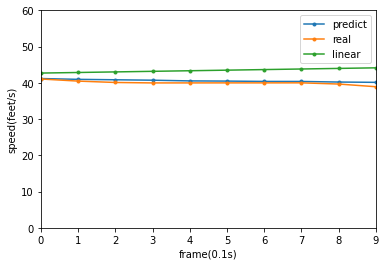

In [96]:
i =5
import matplotlib.pyplot as plt
plt.plot(predict_list[i], label='predict', marker='.')
plt.plot(real_list[i], label = 'real', marker='.')
plt.plot(np_test_prediction[i], label = 'linear', marker='.')
plt.ylim((0, 60))
plt.xlim((0, 9))
plt.legend()
plt.xlabel('frame(0.1s)')
plt.ylabel('speed(feet/s)')
name = 'p_' + str(i) + '.png'
plt.savefig('..//images//predict//' + name, dpi=300)

In [46]:
real_df = pd.DataFrame(real_list).to_csv(r'../images/test_real_y.csv')
predict_df = pd.DataFrame(predict_list).to_csv(r'../images/test_predict_y.csv')

In [47]:
real_np = np.array(real_list)
predict_np = np.array(predict_list)

In [81]:
sqe = np.square(real_np - predict_np)

In [83]:
np.sqrt(np.average(sqe))

5.171470639520963

In [84]:
np.sqrt(sqe)

array([[2.15671737, 2.5276032 , 2.55043814, ..., 1.14341579, 0.44247074,
        0.5214954 ],
       [2.17169867, 3.12618277, 3.70008672, ..., 3.26746681, 3.14991522,
        2.97396725],
       [0.18155226, 0.57198111, 0.51141809, ..., 1.39859971, 1.48865923,
        1.45972867],
       ...,
       [1.01238409, 1.03824913, 1.10861347, ..., 0.96634719, 0.94630691,
        0.8940635 ],
       [7.53707974, 7.90735029, 8.06740403, ..., 7.58390725, 7.50443568,
        7.34646579],
       [1.04713292, 1.20954125, 1.30178047, ..., 1.4967928 , 1.52958747,
        1.56372643]])

In [75]:
np_test_prediction = np.array(test_y_linear_pred) * std_v + mean_v

In [76]:
np.sqrt(np.average(np.square(np_test_prediction - real_np)))

4.558887243622077

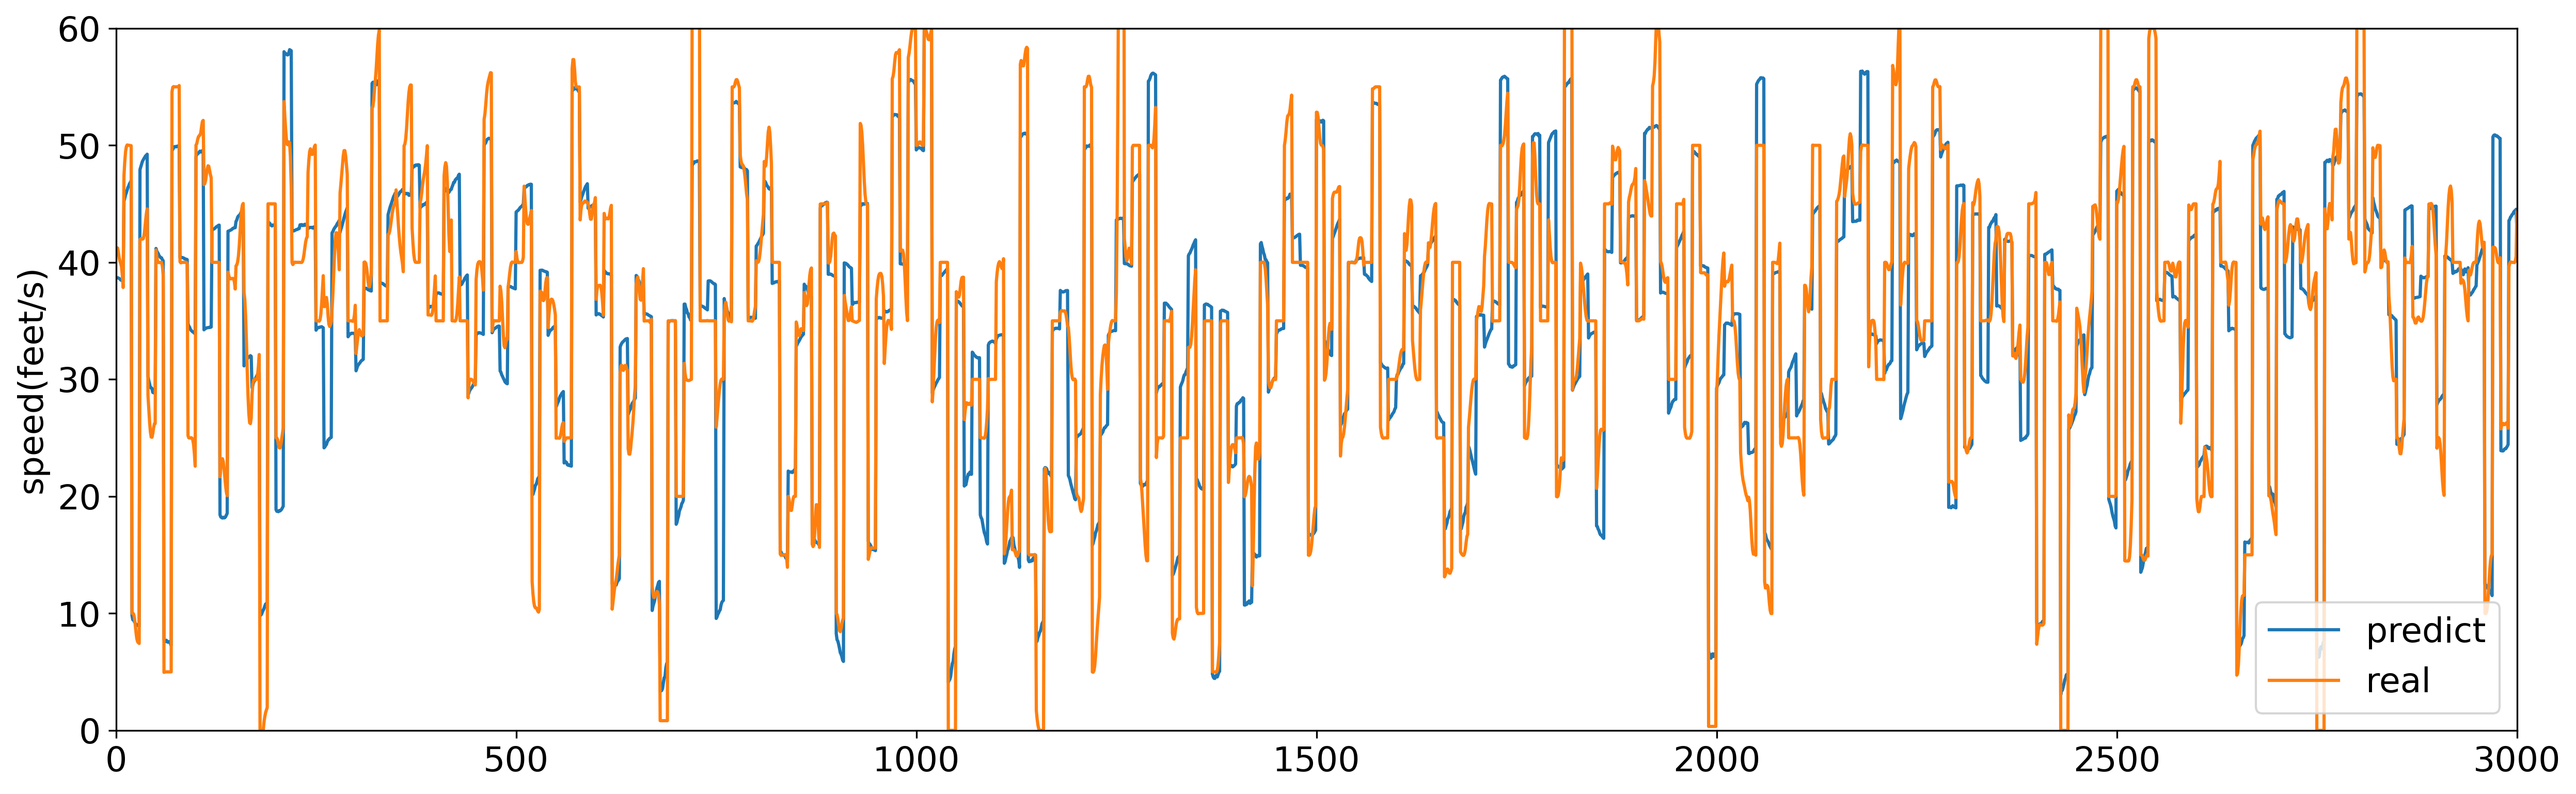

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)
plt.plot(np.array(predict_list).reshape(-1), label='predict')
plt.plot(np.array(real_list).reshape(-1), label = 'real')

plt.ylim((0, 60))
plt.xlim((0, 3000))
plt.legend(fontsize=16)
# plt.xlabel('frame(0.1s)')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.ylabel('speed(feet/s)', fontsize=16)
name = 'p_total' + '.png'
plt.savefig('..//images//predict//' + name, dpi=300)

### Linear Regression

In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import datasets,linear_model

In [52]:
test_x_list = pd.read_csv("../images/test_x_list.csv")
test_y_list = pd.read_csv("../images/test_y_list.csv")
print(test_x_list, test_y_list)

     Unnamed: 0         0         1         2         3         4         5  \
0             0  0.760999  0.760999  0.760999  0.760999  0.760999  0.760999   
1             1  0.688537  0.722306  0.784215  0.866526  0.949540  1.011449   
2             2 -0.995670 -0.995670 -0.995670 -0.995670 -0.995670 -0.995670   
3             3  1.104313  1.117679  1.105720  1.081800  1.057177  1.039590   
4             4  0.327636  0.327636  0.327636  0.327636  0.338188  0.362108   
..          ...       ...       ...       ...       ...       ...       ...   
632         632  1.031147  1.031147  1.031147  1.031147  1.031147  1.031147   
633         633  0.679391  0.679391  0.679391  0.679391  0.679391  0.679391   
634         634  0.327636  0.327636  0.327636  0.327636  0.327636  0.327636   
635         635  0.680798  0.679391  0.679391  0.679391  0.679391  0.679391   
636         636  0.944615  0.944615  0.940394  0.946726  0.971349  1.003710   

            6         7         8  ...        10   

In [53]:
len(test_x_list)

637

In [54]:
test_y_linear_pred = []
rmse_linear_pred = []
for i in range(len(test_x_list)):
    regr=linear_model.LinearRegression() #Linear regression object
    regr.fit(np.arange(1,21)[:,np.newaxis],test_x_list.iloc[i,1:21])
    test_y_list_pred=regr.predict(np.arange(21,31)[:,np.newaxis]) 
    test_y_linear_pred.append(test_y_list_pred)
    rmse_linear_pred.append(np.sqrt(mean_squared_error(test_y_list.iloc[i,1:11], test_y_list_pred)))

In [55]:
pre_linear = pd.DataFrame(test_y_linear_pred)
pre_linear['rmse_linear_pred'] = rmse_linear_pred
pre_linear
pre_linear.to_csv(r'../images/pre_linear.csv')

In [56]:
pre_linear

,0,1,2,3,4,5,6,7,8,9,rmse_linear_pred
0,0.695280,0.690244,0.685207,0.680171,0.675135,0.670099,0.665063,0.660026,0.654990,0.649954,0.060826
1,1.142598,1.157920,1.173241,1.188562,1.203883,1.219205,1.234526,1.249847,1.265168,1.280489,0.144011
2,-1.462195,-1.490220,-1.518246,-1.546272,-1.574298,-1.602323,-1.630349,-1.658375,-1.686400,-1.714426,0.072030
3,0.857621,0.843761,0.829901,0.816041,0.802182,0.788322,0.774462,0.760603,0.746743,0.732883,0.128765
4,-0.066061,-0.091720,-0.117379,-0.143038,-0.168697,-0.194356,-0.220016,-0.245675,-0.271334,-0.296993,0.132039
...,...,...,...,...,...,...,...,...,...,...,...
632,1.010542,1.009584,1.008627,1.007670,1.006712,1.005755,1.004797,1.003840,1.002883,1.001925,0.038180
633,0.597617,0.592255,0.586892,0.581530,0.576167,0.570805,0.565442,0.560080,0.554717,0.549354,0.161537
634,0.258192,0.253863,0.249534,0.245205,0.240876,0.236547,0.232218,0.227889,0.223560,0.219231,0.090128
635,0.835719,0.846299,0.856880,0.867460,0.878040,0.888620,0.899200,0.909780,0.920361,0.930941,0.146168


In [ ]:
test_y_linear
for data in test_y_linear_pred:
    data.tolist

In [63]:
rmse_linear = list(pre_linear['rmse_linear_pred'])
ave_rmse_linear = sum(rmse_linear)/len(rmse_linear)
ave_rmse_linear = ave_rmse_linear * std_v
print(ave_rmse_linear)

2.6582598880474517


In [66]:
print(std_v)

14.214402456137478


In [65]:
sorted(rmse_linear)

[3.798080010219973e-10,
 3.2322681198238e-08,
 3.2322681198238e-08,
 3.2322681198238e-08,
 5.5711943502956274e-08,
 5.5711943502956274e-08,
 5.5711943502956274e-08,
 9.189179728252839e-08,
 0.0017891362242378934,
 0.0020251736414445493,
 0.0022567096569555533,
 0.0028052412698005664,
 0.0028402943575482073,
 0.004534397750931169,
 0.0050803168306713525,
 0.005167109123190115,
 0.006654894095078776,
 0.0073043361886153905,
 0.007563979489136847,
 0.008859842824351614,
 0.00914107663998819,
 0.009857758634780635,
 0.010904028895627216,
 0.01126636489948878,
 0.012174850166965364,
 0.01230794496237495,
 0.01281151496145471,
 0.01507508087139719,
 0.017481667097154638,
 0.017581704562588694,
 0.018198967319114783,
 0.019027802980366767,
 0.019429900732931615,
 0.020310832748699596,
 0.020320360251396413,
 0.020429012648318638,
 0.020883106787612106,
 0.02101140967691325,
 0.021344069347823985,
 0.02150791210464493,
 0.021816412145634286,
 0.02219174333400291,
 0.022398458697236705,
 0.0234

In [62]:
predict_list
real_list
test_y_linear_pred

[array([0.69527973, 0.69024354, 0.68520734, 0.68017115, 0.67513496,
        0.67009877, 0.66506257, 0.66002638, 0.65499019, 0.649954  ]),
 array([1.14259846, 1.15791967, 1.17324089, 1.18856211, 1.20388333,
        1.21920455, 1.23452576, 1.24984698, 1.2651682 , 1.28048942]),
 array([-1.46219475, -1.49022044, -1.51824613, -1.54627182, -1.5742975 ,
        -1.60232319, -1.63034888, -1.65837457, -1.68640026, -1.71442595]),
 array([0.85762063, 0.84376092, 0.82990121, 0.8160415 , 0.80218179,
        0.78832208, 0.77446236, 0.76060265, 0.74674294, 0.73288323]),
 array([-0.06606075, -0.09171989, -0.11737903, -0.14303817, -0.16869731,
        -0.19435644, -0.22001558, -0.24567472, -0.27133386, -0.296993  ]),
 array([0.86901012, 0.88031867, 0.89162723, 0.90293579, 0.91424434,
        0.9255529 , 0.93686145, 0.94817001, 0.95947856, 0.97078712]),
 array([-1.65646768, -1.67027556, -1.68408343, -1.69789131, -1.71169918,
        -1.72550705, -1.73931493, -1.7531228 , -1.76693068, -1.78073855]),
 arr